In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
%matplotlib inline
sns.set(style="ticks")

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [61]:
data = pd.read_csv('company.csv', sep=",")

In [63]:
data.head()

,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Operating Profit Per Share (Yuan ??),Total Asset Growth Rate,Total debt/Total net worth,Debt ratio %,Current Liability to Current Assets
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256970e-04,0.0,0.458143,0.000725,0.0,0.095921,4.980000e+09,0.021266,0.207576,0.118250
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897850e-04,0.0,0.461867,0.000647,0.0,0.093722,6.110000e+09,0.012502,0.171176,0.047775
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361300e-04,25500000.0,0.458521,0.000790,0.0,0.092338,7.280000e+09,0.021248,0.207516,0.025346
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,1.078890e-04,0.0,0.465705,0.000449,0.0,0.077762,4.880000e+09,0.009572,0.151465,0.067250
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,7.890000e+09,0.0,0.462746,0.000686,0.0,0.096898,5.510000e+09,0.005150,0.106509,0.047725


In [64]:
data.shape

(6819, 21)

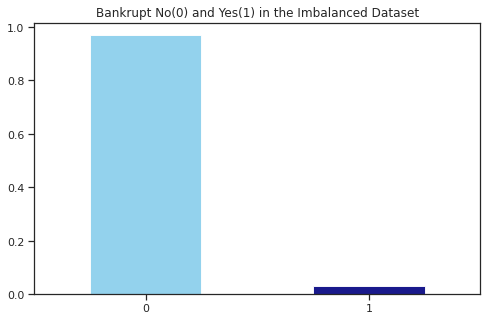

In [65]:
fig = plt.figure(figsize = (8,5))
data.Bankrupt.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('Bankrupt No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

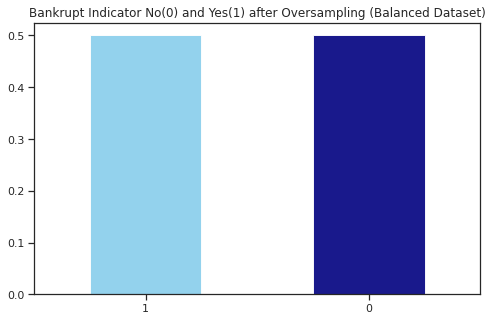

In [66]:
from sklearn.utils import resample

no = data[data.Bankrupt == 0]
yes = data[data.Bankrupt == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.Bankrupt.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('Bankrupt Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [67]:
oversampled.shape

(13198, 21)

**Устранение пропусков в данных**

**Заполнение значений для одного признака**

In [68]:
data.isnull().sum()

Bankrupt                                                   0
ROA(C) before interest and depreciation before interest    0
ROA(A) before interest and % after tax                     0
ROA(B) before interest and depreciation after tax          0
Operating Gross Margin                                     0
Realized Sales Gross Margin                                0
Operating Profit Rate                                      0
Pre-tax net Interest Rate                                  0
After-tax net Interest Rate                                0
Non-industry income and expenditure/revenue                0
Continuous interest rate (after tax)                       0
Operating Expense Rate                                     0
Research and development expense rate                      0
Cash flow rate                                             0
Interest-bearing debt interest rate                        0
Tax rate (A)                                               0
Operating Profit Per Sha

In [69]:
missing_values=data.isnull().sum() # missing values

percent_missing = data.isnull().sum()/data.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
     'data type' : data.dtypes
}
frame=pd.DataFrame(value)
frame

,missing_values,percent_missing %,data type
Bankrupt,0,0.0,int64
ROA(C) before interest and depreciation before interest,0,0.0,float64
ROA(A) before interest and % after tax,0,0.0,float64
ROA(B) before interest and depreciation after tax,0,0.0,float64
Operating Gross Margin,0,0.0,float64
Realized Sales Gross Margin,0,0.0,float64
Operating Profit Rate,0,0.0,float64
Pre-tax net Interest Rate,0,0.0,float64
After-tax net Interest Rate,0,0.0,float64
Non-industry income and expenditure/revenue,0,0.0,float64


No missing data.

**Кодирование категориальных признаков**

**Нормализация числовых признаков**

In [70]:
import scipy.stats as stats

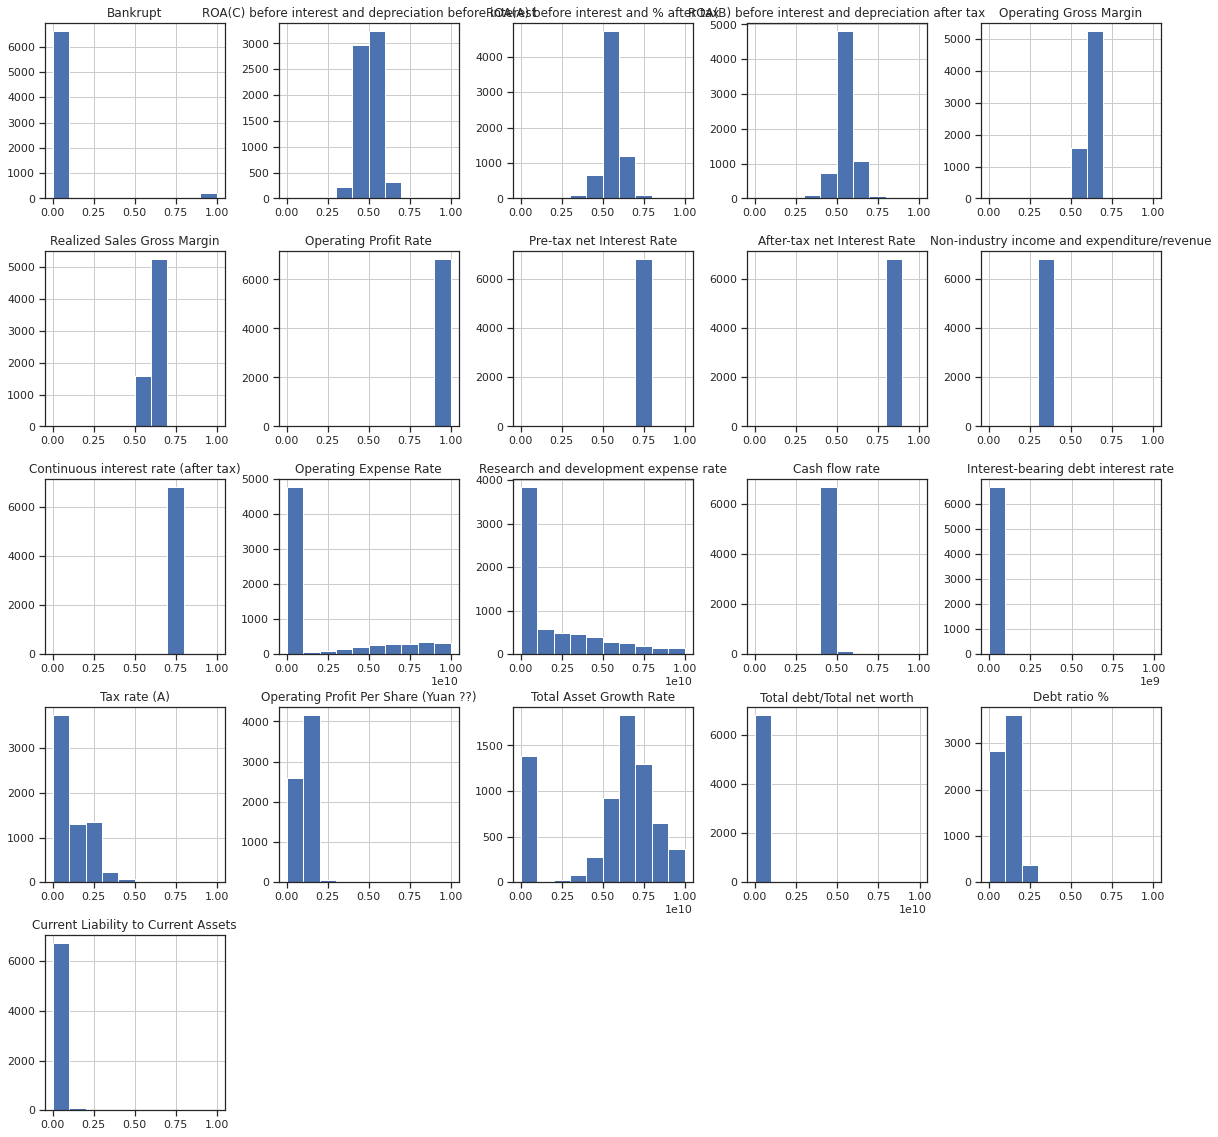

In [71]:
data.hist(figsize=(20, 20))
plt.show()

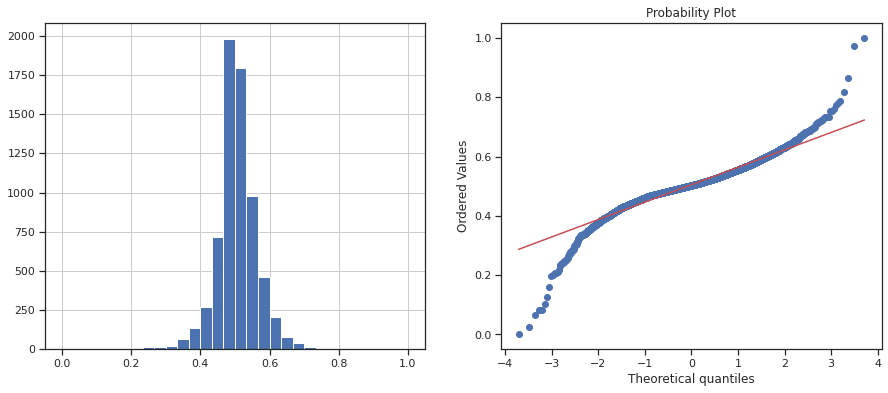

In [73]:
diagnostic_plots(data, 'ROA(C) before interest and depreciation before interest')

In [74]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

Преобразование Йео-Джонсона

Оптимальное значение λ = 1.9758823534356225


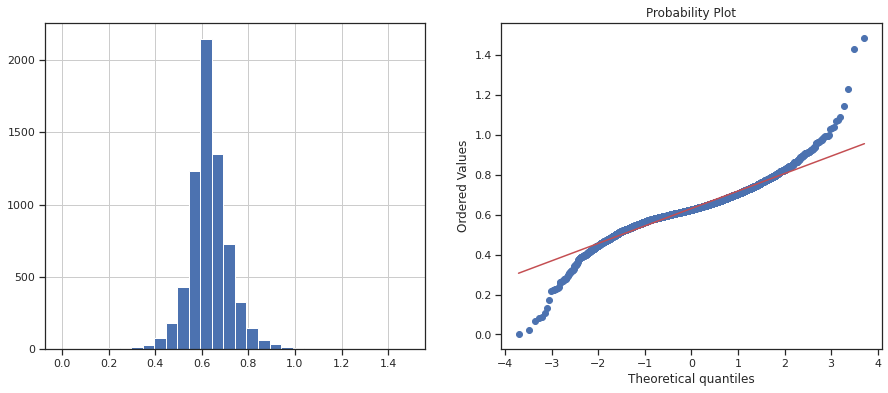

In [75]:
data['ROA'] = data['ROA(C) before interest and depreciation before interest'].astype('float')
data['ROA_yeojohnson'], param = stats.yeojohnson(data['ROA']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(data, 'ROA_yeojohnson')

**Масштабирование признаков**

**На основе Z-оценки**

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 23 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt                                                 6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

In [81]:
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=data.columns)
    return res

In [82]:
cs11 = StandardScaler()
data_cs11_scaled_temp = cs11.fit_transform(data)
# формируем DataFrame на основе массива
data_cs11_scaled =  arr_to_df(data_cs11_scaled_temp)
data_cs11_scaled

,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Operating Profit Per Share (Yuan ??),Total Asset Growth Rate,Total debt/Total net worth,Debt ratio %,Current Liability to Current Assets,ROA,ROA_yeojohnson
0,5.476811,-2.217909,-2.045798,-2.400361,-0.383334,-0.382638,0.016456,-0.023516,-0.020165,-0.087479,-0.031281,-0.616334,-0.750713,-0.545256,-0.151921,-0.829388,-0.471371,-0.182259,-0.026226,1.750845,2.812493,-2.217909,-2.151113
1,5.476811,-0.673828,-0.311068,-0.598450,0.135068,0.136307,0.014671,0.014799,0.015966,-0.005957,0.009823,-0.616334,-0.750713,-0.326632,-0.151921,-0.829388,-0.550058,0.207732,-0.026226,1.075727,0.527485,-0.673828,-0.687884
2,5.476811,-1.303672,-0.908420,-1.319910,-0.383759,-0.388177,0.007858,-0.061111,-0.051183,-0.142238,-0.086567,-0.616334,-0.740898,-0.523098,-0.151921,-0.829388,-0.599601,0.611527,-0.026226,1.749724,-0.199721,-1.303672,-1.296145
3,5.476811,-1.735886,-1.636209,-1.556340,-1.441418,-1.441832,-0.004257,-0.017313,-0.008676,-0.024491,-0.011078,-0.616334,-0.750713,-0.101310,-0.151921,-0.829388,-1.121264,-0.216772,-0.026226,0.710131,1.158899,-1.735886,-1.704465
4,5.476811,-0.661778,-0.307745,-0.508050,-0.541238,-0.540707,0.016758,0.013703,0.016186,-0.013254,0.013300,1.820772,-0.750713,-0.275028,-0.151921,-0.829388,-0.436400,0.000657,-0.026226,-0.123674,0.525867,-0.661778,-0.676093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,-0.182588,-0.189395,-0.291959,-0.168181,-0.206277,-0.204970,0.018215,0.017035,0.018197,-0.010092,0.016277,-0.616334,0.981322,-0.217024,-0.151921,-0.011748,-0.389771,0.539051,-0.026226,0.212203,-0.115286,-0.189395,-0.209372
6815,-0.182588,-0.494676,-0.310237,-0.477627,-0.569328,-0.568828,0.018223,0.017455,0.017919,-0.009248,0.016145,0.996048,-0.196462,-0.320132,-0.151921,1.850573,-0.375199,-0.099429,-0.026226,-0.258249,-0.001180,-0.494676,-0.512003
6816,-0.182588,-0.534845,-0.379194,-0.534996,0.147411,0.135029,0.017628,0.016412,0.017153,-0.009919,0.013012,-0.616334,-0.750713,0.279314,-0.151921,2.710556,-0.322741,0.166317,-0.026226,-1.376904,-0.776979,-0.534845,-0.551549
6817,-0.182588,0.017875,0.019594,0.007403,-0.005811,-0.004720,0.024494,0.024099,0.023223,-0.011175,0.022233,-0.616334,0.215378,0.510249,-0.151921,0.478106,0.096920,0.601174,-0.026226,-0.485905,-0.278510,0.017875,-0.001801


In [83]:
data_cs11_scaled.describe()

,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Operating Profit Per Share (Yuan ??),Total Asset Growth Rate,Total debt/Total net worth,Debt ratio %,Current Liability to Current Assets,ROA,ROA_yeojohnson
count,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03
mean,2.308227e-15,-3.020144e-16,9.992292e-16,5.694391e-18,4.239004e-16,3.561766e-15,1.630309e-16,-3.309707e-15,-6.184125e-15,-3.775524e-15,1.689123e-14,4.091495e-17,1.854768e-16,-2.355581e-15,6.434377e-17,3.419077e-17,-3.372024e-16,1.337022e-16,1.317515e-17,1.820251e-17,-2.534838e-16,-3.020144e-16,7.634432e-16
std,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00,1.000073e+00
min,-1.825880e-01,-8.325144e+00,-8.513649e+00,-8.988246e+00,-3.590406e+01,-3.594062e+01,-7.677375e+01,-6.195112e+01,-5.949294e+01,-2.719997e+01,-6.163250e+01,-6.163337e-01,-7.507126e-01,-2.744064e+01,-1.519207e-01,-8.293882e-01,-3.904437e+00,-1.900979e+00,-2.622613e-02,-2.099124e+00,-1.021527e+00,-8.325144e+00,-7.011179e+00
25%,-1.825880e-01,-4.721818e-01,-3.517775e-01,-4.272116e-01,-4.431329e-01,-4.431390e-01,1.645584e-02,1.524012e-02,1.676539e-02,-1.403314e-02,1.462241e-02,-6.163337e-01,-7.507126e-01,-3.448010e-01,-1.519207e-01,-8.293882e-01,-4.655428e-01,-2.236740e-01,-2.622613e-02,-7.472048e-01,-4.368236e-01,-4.721818e-01,-4.898298e-01
50%,-1.825880e-01,-4.077099e-02,1.793264e-02,-2.128177e-02,-1.151949e-01,-1.154961e-01,2.053269e-02,2.128206e-02,2.144212e-02,-8.728295e-03,1.999708e-02,-6.163337e-01,-5.548003e-01,-1.380430e-01,-1.519207e-01,-2.993821e-01,-1.741111e-01,3.078177e-01,-2.622613e-02,-3.283544e-02,-1.267482e-01,-4.077099e-02,-6.070485e-02
75%,-1.825880e-01,5.007018e-01,4.653235e-01,4.954748e-01,3.523454e-01,3.495522e-01,2.608843e-02,3.023739e-02,2.835899e-02,-3.380179e-03,2.791796e-02,6.639964e-01,5.771803e-01,2.097379e-01,-1.519207e-01,6.551397e-01,2.528364e-01,6.494909e-01,-2.622613e-02,6.607869e-01,2.226884e-01,5.007018e-01,4.883119e-01
max,5.476811e+00,8.154428e+00,6.726718e+00,7.248079e+00,2.315372e+01,2.317910e+01,9.569263e-02,1.576077e+01,1.403833e+01,6.238473e+01,1.724383e+01,2.469432e+00,3.090554e+00,3.126456e+01,8.992132e+00,6.382636e+00,3.188629e+01,1.546815e+00,5.900181e+01,1.644813e+01,3.140134e+01,8.154428e+00,9.485302e+00


In [84]:
# Построение плотности распределения
def draw_kde(col_list, df1, df2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(12, 5))
    # первый график
    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)
    # второй график
    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()

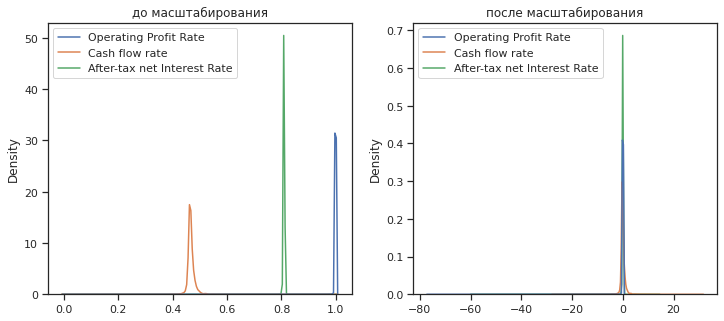

In [86]:
draw_kde(['Operating Profit Rate', 'Cash flow rate', 'After-tax net Interest Rate'], data, data_cs11_scaled, 'до масштабирования', 'после масштабирования')

#Отбор признаков (Feature selection)

In [93]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston


In [94]:
iris = load_iris()
iris_X = iris.data
iris_y = iris.target
iris_feature_names = iris['feature_names']
iris_x_df = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])

In [95]:
boston = load_boston()
boston_X = boston.data
boston_y = boston.target
boston_feature_names = boston['feature_names']
boston_x_df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])

In [97]:
from IPython.display import Image

In [98]:
Image('img/fs_filter.png', width='100%')

In [99]:
lst_arr_1211 = [[1,2,1,21], [1,2,2,22], [1,2,3,23], [1,2,4,24], 
                [1,2,5,25], [1,2,6,26], [1,2,7,27], [1,1,8,28]]
arr_1211 = np.array(lst_arr_1211)
data_1211 = pd.DataFrame(arr_1211, columns=['f1', 'f2', 'f3', 'f4'])
data_1211

,f1,f2,f3,f4
0,1,2,1,21
1,1,2,2,22
2,1,2,3,23
3,1,2,4,24
4,1,2,5,25
5,1,2,6,26
6,1,2,7,27
7,1,1,8,28


In [101]:
from sklearn.feature_selection import VarianceThreshold

In [102]:
selector_1211 = VarianceThreshold(threshold=0.15)
selector_1211.fit(data_1211)
# Значения дисперсий для каждого признака
selector_1211.variances_

array([0.      , 0.109375, 5.25    , 5.25    ])

In [103]:
# Константный и псевдоконстантный признаки удалены
selector_1211.transform(data_1211)

array([[ 1, 21],
       [ 2, 22],
       [ 3, 23],
       [ 4, 24],
       [ 5, 25],
       [ 6, 26],
       [ 7, 27],
       [ 8, 28]])

In [104]:
lst_arr_1212 = [[21,1,2,21,1,3,21], 
                [22,2,2,22,2,3,22], 
                [23,3,2,23,3,3,23], 
                [24,4,2,24,4,3,24]]
arr_1212 = np.array(lst_arr_1212)
data_1212 = pd.DataFrame(arr_1212, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'])
data_1212

,f1,f2,f3,f4,f5,f6,f7
0,21,1,2,21,1,3,21
1,22,2,2,22,2,3,22
2,23,3,2,23,3,3,23
3,24,4,2,24,4,3,24


In [105]:
def get_duplicates(X):
    """
    Поиск дубликатов в колонках
    X - DataFrame
    """
    
    pairs = {}
    dups = []

    # Перебор всех колонок (внешний)
    for i in range(X.shape[1]):

        # текущая колонка
        feat_outer = X.columns[i]

        # если текущая колонка не является дублем
        if feat_outer not in dups:

            # создаем запись в словаре, колонка является ключом
            pairs[feat_outer] = []

            # Перебор оставшихся колонок (внутренний)
            for feat_inner in X.columns[i + 1:]:

                # Если колонки идентичны
                if X[feat_outer].equals(X[feat_inner]):

                    # добавление в словарь и список дубликатов
                    pairs[feat_outer].append(feat_inner)
                    dups.append(feat_inner)

    return pairs

In [106]:
get_duplicates(data_1212)

{'f1': ['f4', 'f7'], 'f2': ['f5'], 'f3': [], 'f6': []}

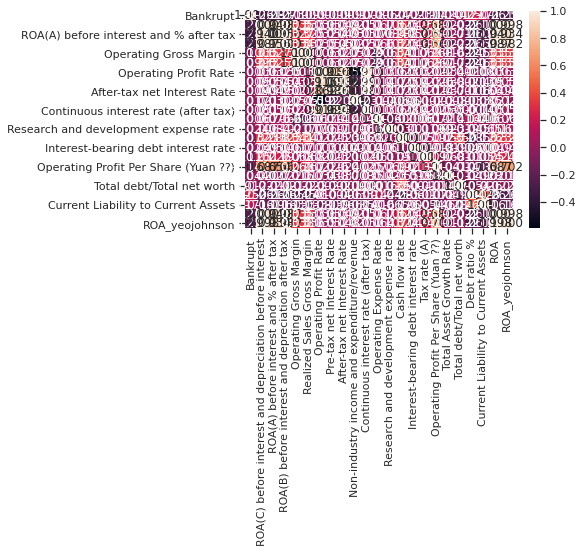

In [108]:
sns.heatmap(data.corr(), annot=True, fmt='.3f')

In [109]:
# Формирование DataFrame с сильными корреляциями
def make_corr_df(df):
    cr = data.corr()
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.8]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

In [110]:
make_corr_df(data)

,f1,f2,corr
0,Operating Gross Margin,Realized Sales Gross Margin,0.999518
1,Realized Sales Gross Margin,Operating Gross Margin,0.999518
2,ROA_yeojohnson,ROA(C) before interest and depreciation before...,0.998379
3,ROA(C) before interest and depreciation before...,ROA_yeojohnson,0.998379
4,ROA_yeojohnson,ROA,0.998379
5,ROA,ROA_yeojohnson,0.998379
6,Continuous interest rate (after tax),Pre-tax net Interest Rate,0.993617
7,Pre-tax net Interest Rate,Continuous interest rate (after tax),0.993617
8,ROA,ROA(B) before interest and depreciation after tax,0.986849
9,ROA(C) before interest and depreciation before...,ROA(B) before interest and depreciation after tax,0.986849


In [111]:
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

In [112]:
# Группы коррелирующих признаков
corr_groups(make_corr_df(data))

[['Realized Sales Gross Margin', 'Operating Gross Margin'],
 ['ROA(C) before interest and depreciation before interest',
  'ROA',
  'ROA(B) before interest and depreciation after tax',
  'ROA(A) before interest and % after tax',
  'ROA_yeojohnson'],
 ['Pre-tax net Interest Rate',
  'After-tax net Interest Rate',
  'Operating Profit Rate',
  'Continuous interest rate (after tax)']]

Методы, основанные на статистических характеристиках (univariate feature selection)

In [114]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

Text(0, 0.5, 'Взаимная информация')

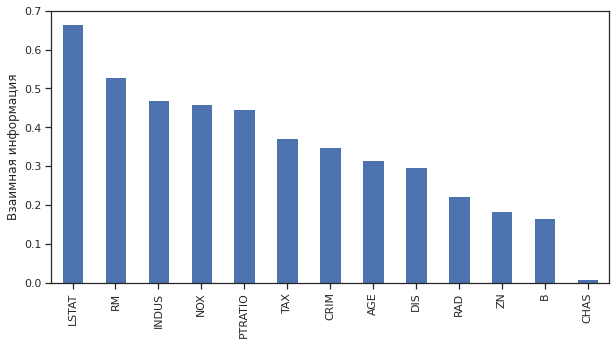

In [115]:
mi = mutual_info_regression(boston_X, boston_y)
mi = pd.Series(mi)
mi.index = boston_feature_names
mi.sort_values(ascending=False).plot.bar(figsize=(10,5))
plt.ylabel('Взаимная информация')

In [118]:
sel_mi = SelectKBest(mutual_info_regression, k=5).fit(boston_X, boston_y)

list(zip(boston_feature_names, sel_mi.get_support()))

[('CRIM', False),
 ('ZN', False),
 ('INDUS', True),
 ('CHAS', False),
 ('NOX', True),
 ('RM', True),
 ('AGE', False),
 ('DIS', False),
 ('RAD', False),
 ('TAX', False),
 ('PTRATIO', True),
 ('B', False),
 ('LSTAT', True)]

In [119]:
boston_feature_names[sel_mi.get_support()]

array(['INDUS', 'NOX', 'RM', 'PTRATIO', 'LSTAT'], dtype='<U7')

#Улучшенная выборка

In [121]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = data.drop('Bankrupt', axis=1)
y = data['Bankrupt']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Interest-bearing debt interest rate', 'Total debt/Total net worth', 'Debt ratio %', 'Current Liability to Current Assets']
[0.04046892 0.04878069 0.04700676 0.03269395 0.03237548 0.03519169
 0.03700317 0.05092466 0.05031097 0.0604523  0.04275354 0.03196185
 0.03474278 0.05981937 0.00863221 0.03931195 0.03494951 0.08675828
 0.09263232 0.05608316 0.03900202 0.03814446]


In [122]:
X = selector.transform(X)
# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [123]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [124]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.9642228739002933
ROC Area under Curve = 0.5639311043566362
Cohen's Kappa = 0.19528801887887337
Time taken = 0.7900946140289307
              precision    recall  f1-score   support

           0    0.96919   0.99453   0.98170      1645
           1    0.47059   0.13333   0.20779        60

    accuracy                        0.96422      1705
   macro avg    0.71989   0.56393   0.59475      1705
weighted avg    0.95165   0.96422   0.95446      1705



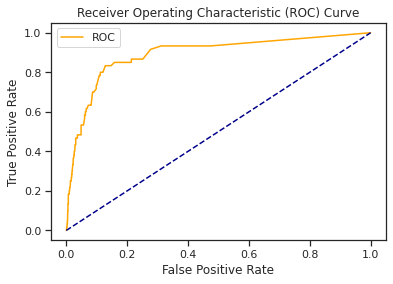

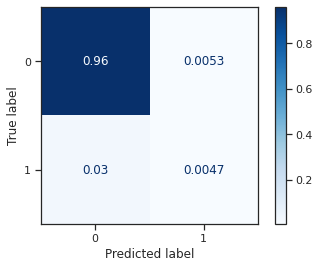

In [125]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

#Минимальная предобработкя данных

In [128]:
df = pd.read_csv('company.csv')

In [129]:
l_columns = [x.lower() for x in df.columns]
df.columns = l_columns
name = []
null = []
for i in df.columns:
    name.append(i)
    null.append(df[i].isnull().sum() / len(df))
    
null_desc = pd.DataFrame({"col_name" : name, "null_per": null})
null_desc.sort_values(by="null_per", ascending=False)

,col_name,null_per
0,bankrupt,0.0
11,operating expense rate,0.0
19,debt ratio %,0.0
18,total debt/total net worth,0.0
17,total asset growth rate,0.0
16,operating profit per share (yuan ??),0.0
15,tax rate (a),0.0
14,interest-bearing debt interest rate,0.0
13,cash flow rate,0.0
12,research and development expense rate,0.0


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 21 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   bankrupt                                                 6819 non-null   int64  
 1   roa(c) before interest and depreciation before interest  6819 non-null   float64
 2   roa(a) before interest and % after tax                   6819 non-null   float64
 3   roa(b) before interest and depreciation after tax        6819 non-null   float64
 4   operating gross margin                                   6819 non-null   float64
 5   realized sales gross margin                              6819 non-null   float64
 6   operating profit rate                                    6819 non-null   float64
 7   pre-tax net interest rate                                6819 non-null   float64
 8   after-tax net interest rate 

In [134]:
X2 = df.drop('bankrupt', axis=1)
y2 = df['bankrupt']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=12345)

Accuracy = 0.9671554252199414
ROC Area under Curve = 0.5895390070921986
Cohen's Kappa = 0.27019796682718034
Time taken = 1.1529037952423096
              precision    recall  f1-score   support

           0    0.97095   0.99574   0.98319      1645
           1    0.61111   0.18333   0.28205        60

    accuracy                        0.96716      1705
   macro avg    0.79103   0.58954   0.63262      1705
weighted avg    0.95829   0.96716   0.95852      1705



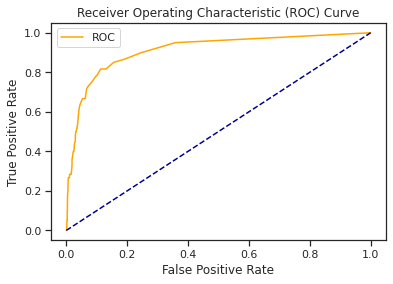

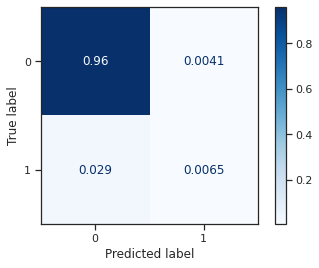

In [135]:
params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X2_train, y2_train, X2_test, y2_test)

#AutoXML

In [138]:
pip install tpot

     |████████████████████████████████| 92kB 6.9MB/s 
     |████████████████████████████████| 163kB 27.6MB/s 
     |████████████████████████████████| 166.7MB 84kB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11954 sha256=f7eb5475296ad8b267bcf2fd79c89f3f33d761477ef8a6768d899a473ce0944a
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [139]:
from tpot import TPOTClassifier
model3=TPOTClassifier(generations=4,population_size=30,verbosity=2,scoring='accuracy')
model3.fit(X_train,y_train)
print(model3.score(X_test,y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)



Generation 1 - Current best internal CV score: 0.9704730532392928

Generation 2 - Current best internal CV score: 0.9704730532392928

Generation 3 - Current best internal CV score: 0.9710605199778863

Generation 4 - Current best internal CV score: 0.9710605199778863

Best pipeline: RandomForestClassifier(RobustScaler(input_matrix), bootstrap=True, criterion=gini, max_features=0.6500000000000001, min_samples_leaf=6, min_samples_split=12, n_estimators=100)
0.963049853372434
